In [183]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [184]:
#한글 깨짐 방지
from matplotlib import rc, font_manager
font_path='../data/fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)
#마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus']=False

In [185]:
# mackerel=pd.read_csv('../data/merge/mackerel_price.csv')
mackerel=pd.read_csv('../data/merge/mackerel_price_trade.csv')

# '%Y-%m' 형식으로 변환
mackerel['date'] = pd.to_datetime(mackerel['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
mackerel.set_index('date', inplace=True)
mackerel=mackerel[['생산량','갈치','참조기','수입','수출','가격 (원)']]
# mackerel=mackerel[[,'생산량','가격 (원)']]
mackerel.info()
mackerel

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   생산량     108 non-null    int64
 1   갈치      108 non-null    int64
 2   참조기     108 non-null    int64
 3   수입      108 non-null    int64
 4   수출      108 non-null    int64
 5   가격 (원)  108 non-null    int64
dtypes: int64(6)
memory usage: 5.9 KB


,생산량,갈치,참조기,수입,수출,가격 (원)
date,,,,,,
2014-01-01,5663,2805,3,3476,4840,3422
2014-02-01,3565,1436,1,1101,3402,4073
2014-03-01,2620,2740,1,2011,2033,3891
2014-04-01,1525,2894,6,2454,2122,4259
2014-05-01,412,908,3,1995,755,3512
...,...,...,...,...,...,...
2022-08-01,3900,682,28,2056,613,3543
2022-09-01,5494,1809,10,2194,1996,3333
2022-10-01,5339,987,239,679,6242,3175


In [186]:
seq_length=3 # 3~7사이 값 설정
train_size = int(len(mackerel)-12)
train_set=mackerel[0:train_size]
test_set=mackerel[train_size-seq_length:]
print(train_set.shape,test_set.shape)


(96, 6) (15, 6)


In [187]:
train_set.head()

,생산량,갈치,참조기,수입,수출,가격 (원)
date,,,,,,
2014-01-01,5663,2805,3,3476,4840,3422
2014-02-01,3565,1436,1,1101,3402,4073
2014-03-01,2620,2740,1,2011,2033,3891
2014-04-01,1525,2894,6,2454,2122,4259
2014-05-01,412,908,3,1995,755,3512


In [188]:
#input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:, :-1])

# output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])
train_set.iloc[:, -1]=scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:, -1]=scaler_y.transform(test_set.iloc[:,[-1]])

In [189]:
test_set[:]

,생산량,갈치,참조기,수입,수출,가격 (원)
date,,,,,,
2021-10-01,0.348104,0.316959,0.323162,0.036125,0.363671,0.429224
2021-11-01,0.493993,0.491581,0.876560,0.098553,0.357424,0.463318
2021-12-01,0.812506,0.530463,0.428571,0.839544,0.577391,0.407002
2022-01-01,0.408929,0.353411,0.023578,0.867690,0.863961,0.511111
2022-02-01,0.065691,0.177226,0.004161,0.746076,0.639871,0.592694
2022-03-01,0.101518,0.342822,0.012483,0.679000,0.486506,0.595129
2022-04-01,0.004531,0.224440,0.004161,0.069619,0.165862,0.683714
2022-05-01,0.006995,0.024996,0.006935,0.312407,0.278905,0.790563
2022-06-01,0.017731,0.063531,0.004161,0.222885,0.176618,0.833486


In [190]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import numpy as np

In [191]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [192]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        y_=time_series[i+seq_length,[5]]
        dataX.append(x_)
        dataY.append(y_)
    return np.array(dataX), np.array(dataY)

In [193]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set),seq_length)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(93, 3, 6) (93, 1)
(12, 3, 6) (12, 1)


In [194]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)
testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

print(trainX_tensor.size(), trainY_tensor.size())
print(testX_tensor.size(), testY_tensor.size())

torch.Size([93, 3, 6]) torch.Size([93, 1])
torch.Size([12, 3, 6]) torch.Size([12, 1])


In [195]:
train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_loader=DataLoader(train_dataset, shuffle=True,
                        drop_last=True)

In [196]:
# 수정 필요

data_dim=6
hidden_dim=12
output_dim=1
learning_late=0.01
epochs=1000

In [197]:
class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim=hidden_dim
    self.seq_length=seq_length
    self.output_dim=output_dim
    self.layers=layers

    self.lstm=nn.LSTM(input_dim, 
                      hidden_dim, 
                      num_layers=layers,
                      batch_first=True)
    self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

  def reset_hidden_state(self):
    self.hidden=(
      torch.zeros(self.layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.layers, self.seq_length, self.hidden_dim)
    )
  def forward(self, x):
    x, _status=self.lstm(x)
    x=self.fc(x[:, -1])
    return x

In [198]:
def train_model(model, train_df, epochs=None, lr=None, verbos=10, patience=10):
  criterion=nn.MSELoss().to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_late)
  n_epochs=epochs

  train_hist=np.zeros(n_epochs)
  for epoch in range(n_epochs):
    avg_cost=0
    total_batch=len(train_df)

    for batch_idxm, sample in enumerate(train_df):
      x_train, y_train=sample
      model.reset_hidden_state()
      output=model(x_train)
      loss=criterion(output, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_cost+=loss/total_batch
    
    train_hist[epoch]=avg_cost

    if epoch % verbos==0:
      print('Epoch:{}, train_loss:{}'.format(epoch, avg_cost.item()))

    if(epoch % patience==0) & (epoch!=0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print("Early Stopping")
        break
  return model.eval(), train_hist

# best loss / model 추가

In [199]:
# net=Net(data_dim, hidden_dim, seq_length, output_dim, 1)
# model, train_hist=train_model(net, train_loader, epochs=epochs,
#                               lr=learning_late, verbos=20, patience=100)

In [221]:
path="../model/price_수입_수출_갈치.pth"
# path="../model/price_final.pth"
# torch.save(model.state_dict(), path)

In [201]:
model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(path), strict=False)
model.eval()

Net(
  (lstm): LSTM(6, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

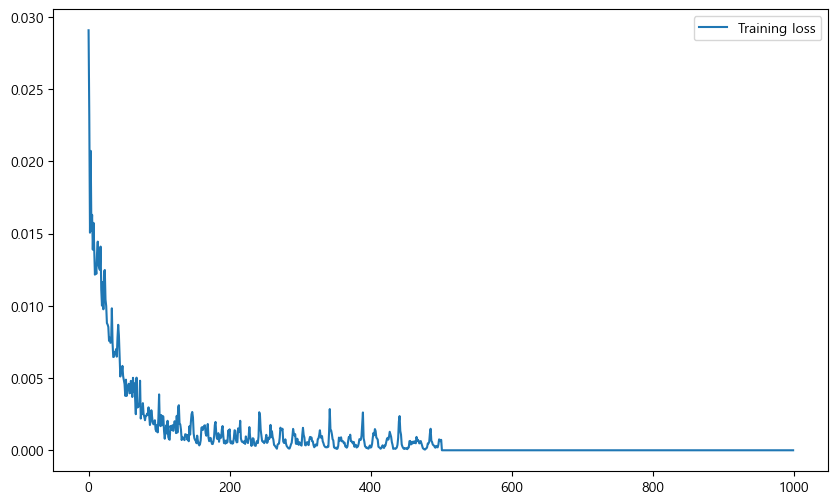

In [202]:
fig=plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training loss')
plt.legend()
plt.show()

In [203]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAe SCORE:', MAE(pred_inverse, testY_inverse))

MAe SCORE: 262.51510329544544


In [204]:
test_set.index[seq_length:]

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [205]:
date=['2023-01','2023-02', '2023-03', '2023-04',
    '2023-05', '2023-06', '2023-07', '2023-08',
    '2023-09', '2023-10', '2023-11', '2023-12']

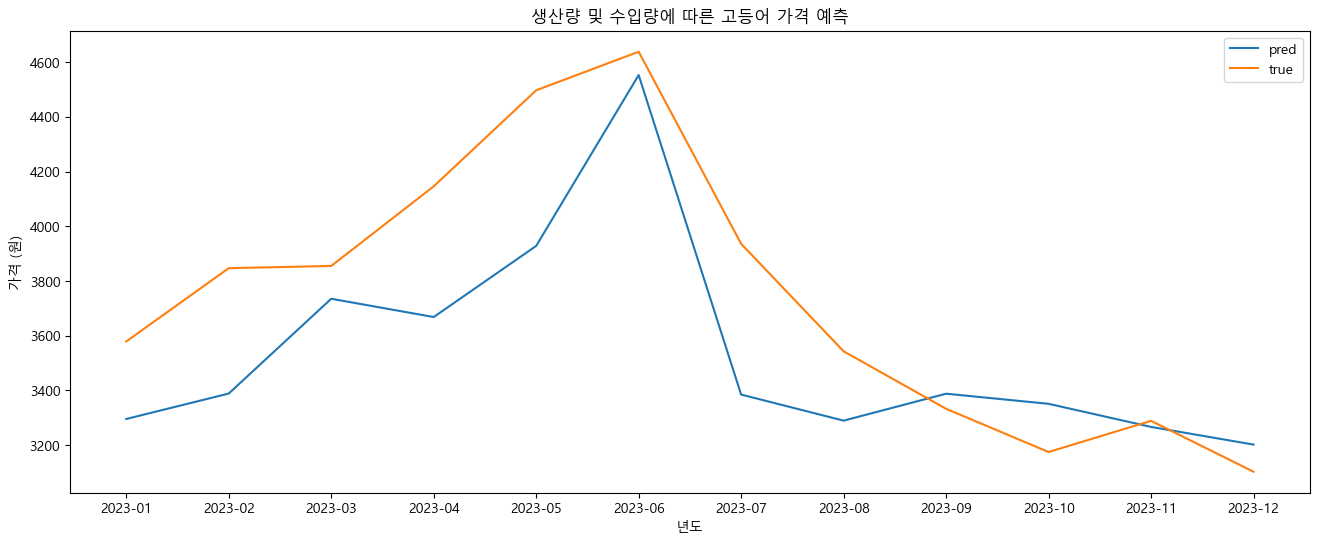

In [206]:
fig=plt.figure(figsize=(16,6))
plt.title('생산량 및 수입량에 따른 고등어 가격 예측')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
plt.xlabel('년도')
plt.ylabel('가격 (원)')

plt.xticks(np.arange(len(pred_inverse)),date)
plt.legend()
plt.show()

# 모델활용 미래 예측
 - 생산량에 따른 고등어 가격(24) 예측

In [214]:
# 데이터 불러오기
pred_product=pd.read_csv('../data/merge/price_pred_values.csv')

pred_product['date'] = pd.to_datetime(pred_product['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
pred_product.set_index('date', inplace=True)

pred_product.head()

,생산량,갈치,참조기,수입,수출
date,,,,,
2024-01-01,1199.0,2132.947236,11.726685,7340.893197,8178.081052
2024-02-01,1199.0,2358.660455,0.000000,10353.117920,8994.719573
2024-03-01,1199.0,1790.544876,34.984615,7125.182607,6168.885166
2024-04-01,1199.0,1159.622157,12.903990,3759.505482,4294.083087
2024-05-01,1199.0,325.399987,0.000000,3734.359067,4379.832152


In [216]:
def build_pred_dataset(time_series, seq_length):
    dataX=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        dataX.append(x_)
    return np.array(dataX)

In [217]:
predX=build_pred_dataset(np.array(pred_product),seq_length)
predX.shape

(9, 3, 5)

In [218]:
predX_tensor=torch.FloatTensor(predX)

In [222]:
model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(path), strict=False)
model.eval()

Net(
  (lstm): LSTM(6, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [224]:
with torch.no_grad():
    pred=[]
    for pr in range(len(predX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(predX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))

In [226]:
date=['2023-04','2024-05','2024-06',
      '2024-07','2024-08', '2024-09','2023-10','2024-11','2024-12']

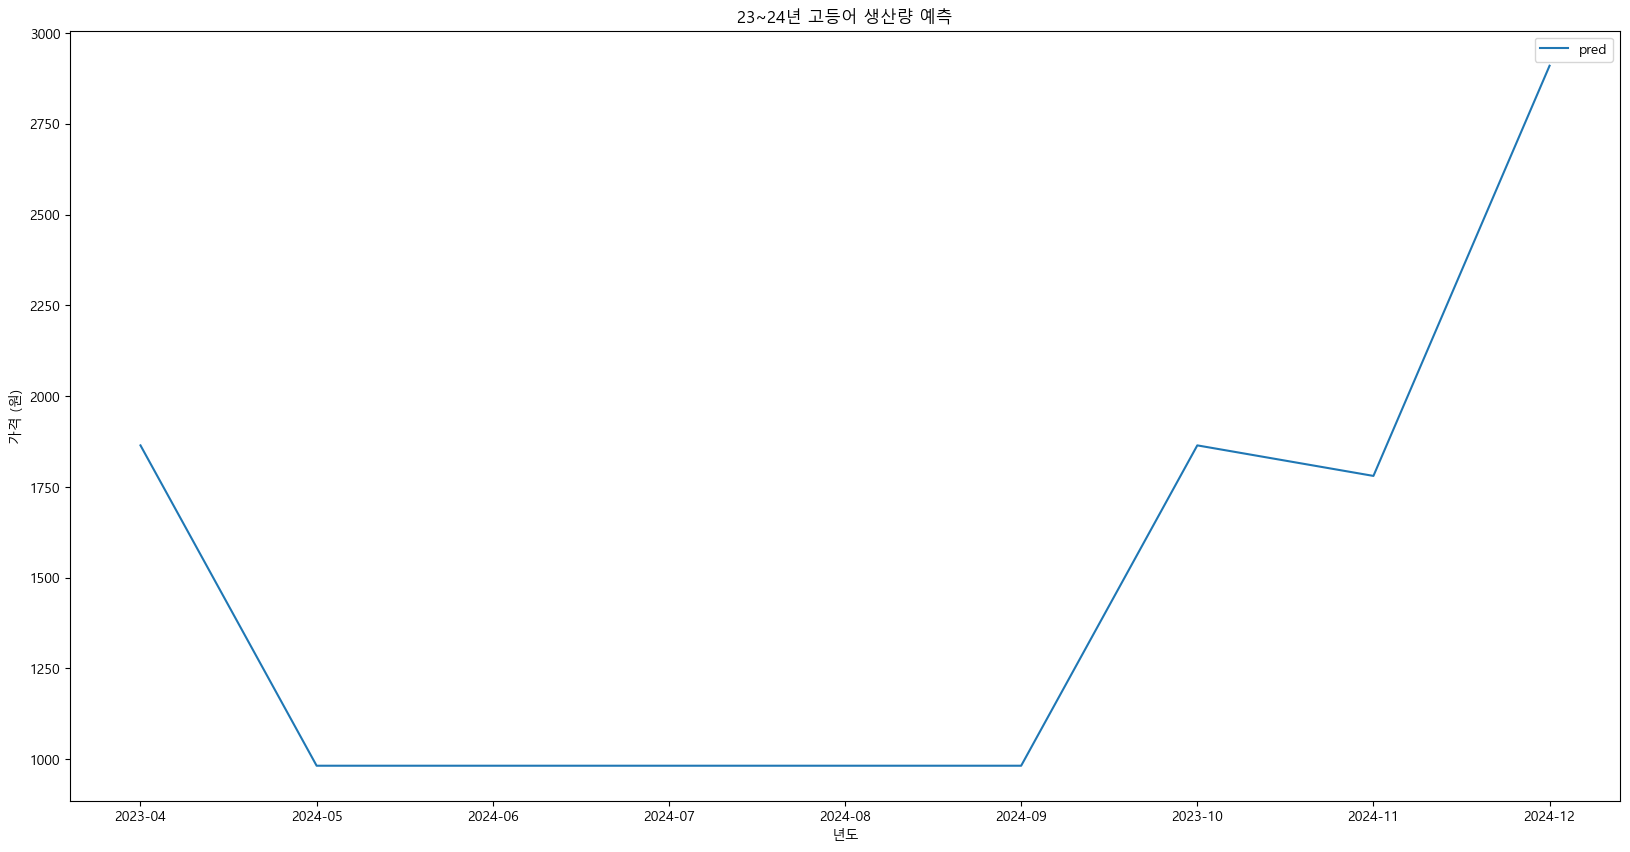

In [228]:
fig=plt.figure(figsize=(20,10))
plt.title('23~24년 고등어 생산량 예측')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.xlabel('년도')
plt.ylabel('가격 (원)')

plt.xticks(np.arange(len(pred_inverse)),date)
plt.legend()
plt.show()

In [229]:
pred_inverse

array([[1864.44112092],
       [ 982.12129593],
       [ 982.12129593],
       [ 982.12129593],
       [ 982.12129593],
       [ 982.12129593],
       [1864.44112092],
       [1780.31834111],
       [2910.10266304]])